## Tweet popularity prediction of the Congress members

In this notebook, we show a use case of the linguistic features generated by the lexicon-based wmd script.

In [118]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split

import shap

In [119]:
df = pd.read_csv('wmd_tweets_wiki-sg300.csv')

/home/guilherme/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [120]:
df.head()

,id_parlamentar,casa,nome_eleitoral,partido,uf,username,created_at,text,favorite_count,reply_count,...,status_url,interactions,clean_tweets,Outrage,Vagueness,Argumentation,Modalization,Valuation,Sentiment,Pressupposition
0,204379,camara,Acácio Favacho,PROS,AP,acaciofavacho,2020-04-17T02:07:17Z,"Estendemos o auxílio emergencial de R$600,00 p...",14,NaN,...,https://twitter.com/AcacioFavacho/status/12509...,21.0,estendemos auxílio emergencial de para taxis...,0.177781,0.175456,0.171303,0.141853,0.152382,0.149631,0.158267
1,204379,camara,Acácio Favacho,PROS,AP,acaciofavacho,2020-04-17T01:49:12Z,"Estendemos o auxílio emergencial de R$600,00 p...",7,NaN,...,https://twitter.com/AcacioFavacho/status/12509...,11.0,estendemos auxílio emergencial de para os ta...,0.177538,0.176536,0.172010,0.140885,0.153102,0.149822,0.157816
2,204379,camara,Acácio Favacho,PROS,AP,acaciofavacho,2020-04-16T22:11:36Z,Parabenizo o Ministro Mandetta pelo excelente ...,11,NaN,...,https://twitter.com/AcacioFavacho/status/12509...,13.0,parabenizo ministro mandetta pelo excelente t...,0.186290,0.182939,0.196203,0.153144,0.196839,0.165387,0.151931
3,204379,camara,Acácio Favacho,PROS,AP,acaciofavacho,2020-04-03T23:04:48Z,PL 1.161/2020 que garante arrecadação do FPM e...,0,NaN,...,https://twitter.com/AcacioFavacho/status/12462...,0.0,pl que garante arrecadação do fpm fpm é proj...,0.144586,0.144683,0.149965,0.130477,0.139174,0.141784,0.112525
4,204379,camara,Acácio Favacho,PROS,AP,acaciofavacho,2020-03-24T17:34:00Z,Protocolei ontem um projeto de Lei que veda à ...,3,NaN,...,https://twitter.com/AcacioFavacho/status/12425...,4.0,protocolei ontem um projeto de lei que veda à ...,0.150452,0.161433,0.148428,0.158644,0.165103,0.135750,0.154598


In [121]:
ex = df.loc[df['nome_eleitoral'] == "Tabata Amaral"].reset_index()

In [122]:
LABEL_COLUMN_NAME = 'interactions'
N_FOLDS = 10
RANDOM_STATE = 10
features = ["Outrage","Vagueness","Argumentation","Modalization","Valuation","Sentiment","Pressupposition"]

def average(lista):
    return sum(lista)/len(lista)

def eval_features(df, features):
    X = df[features].values
    y = df[LABEL_COLUMN_NAME].values

    r2_test = []
    r2_train = []
    rmse = []
    mae = []
    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    for (train, val) in cv.split(X, y):
        regressor = xgb.XGBRegressor(objective ='reg:squarederror',
                 colsample_bytree=0.4,
                 gamma=0.1,                 
                 learning_rate=0.08,
                 max_depth=1,
                 min_child_weight=1.5,
                 n_estimators=23,                                                                    
                 subsample=0.5,
                 seed=42)
        regressor = regressor.fit(X[train], y[train])
        
        y_pred = regressor.predict(X[val])
        

        rmse.append(mean_squared_error(y[val],y_pred)**(1/2))
        mae.append(mean_absolute_error(y[val],y_pred))
    
    print("\nrmse:", average(rmse),"\nmae:", average(mae))
    return

In [123]:
eval_features(ex, features)


rmse: 3377.8891260027826 
mae: 1390.8209969330596


In [124]:
X = ex[features].values
y = ex[LABEL_COLUMN_NAME].values

Xt, Xv, yt, yv = train_test_split(X,y, test_size=0.25, random_state=1)

Now, we will use SHAP to get explanations for our model decisions. To investigate model decisions, we use SHAP summary plots, which allows us (i) to summarize the importance of
a feature, and (ii) to associate low/high feature values to an increase/decrease in output values, through color-coded violin plots built from all predictions. We will further see that different members of parliament have a different summary plot, which shows different strategies between members to engage the public.

In [125]:
import shap
regressor = xgb.XGBRegressor(objective ='reg:squarederror',
                 colsample_bytree=0.4,
                 gamma=0.1,                 
                 learning_rate=0.08,
                 max_depth=1,
                 min_child_weight=1.5,
                 n_estimators=23,                                                                    
                 subsample=0.5,
                 seed=42)
regressor = regressor.fit(Xt, yt)

explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(Xv,check_additivity=False)

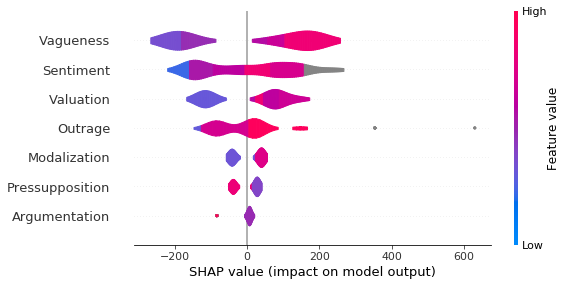

In [126]:
shap.summary_plot(shap_values, Xv, feature_names=features, plot_type="violin")

Now we observe the results for another member of National Congress

In [127]:
ex = df.loc[df['nome_eleitoral'] == "Rodrigo Maia"].reset_index()

In [128]:
eval_features(ex, features)


rmse: 13636.412309912534 
mae: 6388.899208117238


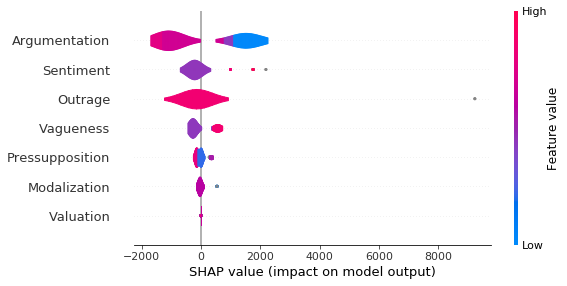

In [134]:
X = ex[features].values
y = ex[LABEL_COLUMN_NAME].values

Xt, Xv, yt, yv = train_test_split(X,y, test_size=0.25, random_state=1)
regressor = xgb.XGBRegressor(objective ='reg:squarederror',
                 colsample_bytree=0.4,
                 gamma=0.1,                 
                 learning_rate=0.08,
                 max_depth=1,
                 min_child_weight=1.5,
                 n_estimators=20,                                                                    
                 subsample=0.5,
                 seed=41)
regressor = regressor.fit(Xt, yt)

explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(Xv,check_additivity=False)
shap.summary_plot(shap_values, Xv, feature_names=features, plot_type="violin")